Loading from ZIP -> order_products__prior.csv
Loading CSV -> ./products.csv
order_products shape: (32434489, 4)
products shape: (49688, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Merged df shape: (32434489, 3)


,order_id,product_id,product_name
0,2,33120,Organic Egg Whites
1,2,28985,Michigan Organic Kale
2,2,9327,Garlic Powder
3,2,45918,Coconut Butter
4,2,30035,Natural Sweetener


Subset df shape: (201667, 3)
Number of baskets: 20000


order_id
2    [Organic Egg Whites, Michigan Organic Kale, Ga...
3    [Total 2% with Strawberry Lowfat Greek Straine...
4    [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
5    [Bag of Organic Bananas, Just Crisp, Parmesan,...
6    [Cleanse, Dryer Sheets Geranium Scent, Clean D...
Name: product_name, dtype: object

Transaction matrix shape: (20000, 21580)


,#2 Coffee Filters,#2 Cone White Coffee Filters,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,0 Calorie Acai Raspberry Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Greek Yogurt Black Cherry on the Bottom,0% Fat Organic Greek Vanilla Yogurt,0% Fat Strawberry Greek Yogurt,0% Fat Superfruits Greek Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,"0% Greek, Blueberry on the Bottom Yogurt",0% Milkfat Greek Plain Yogurt,0% Milkfat Greek Yogurt Honey,1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,1 Apple + 1 Pear Fruit Bar,1 Liter,1 Ply Paper Towels,1 Razor Handle and 2 Freesia Scented Razor Refills Premium BladeRazor System,1 Step Kashmir Spinach Indian Cuisine,...,Zucchini Squash,"Zucchini Squash, Baby Courgette","Zucchini, Spinach & Banana Blend Veggies On-The-Go Stage 2 (6 Months and Up)","\""Mokaccino\"" Milk + Blue Bottle Coffee Chocolate",for Tots Apple Juice,from Concentrate Mango Nectar,gel hand wash sea minerals,go fresh Cool Moisture Beauty,in Gravy with Carrots Peas & Corn Mashed Potatoes & Meatloaf Nuggets,o.b Super Plus Fluid Lock Tampons,of Hanover 100 Calorie Pretzels Mini,of Norwich Original English Mustard Powder Double Superfine,pumpkin spice,smart Blend Chicken & Rice Formula Dry Dog Food,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,w/Banana Pulp Free Juice,with Crispy Almonds Cereal,with Dawn Action Pacs Fresh Scent Dishwasher Detergent Pacs,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Seasoned Roasted Potatoes Scrambled Eggs & Sausage,with Sweet & Smoky BBQ Sauce Cheeseburger Sliders,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


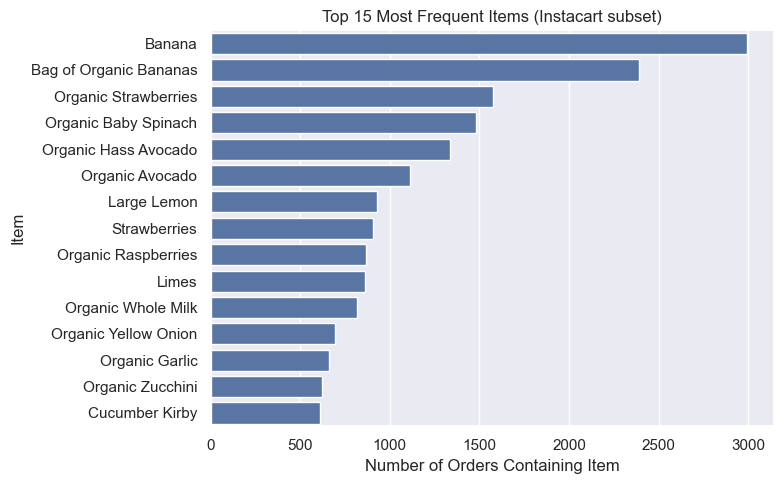

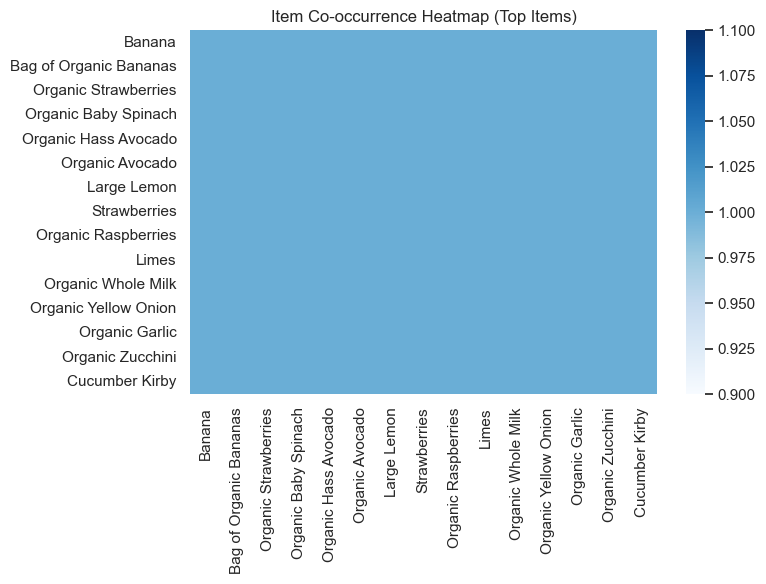

In [2]:
# ============================================
# STEP 0: IMPORTS & GLOBAL SETTINGS
# ============================================

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import zipfile  # for loading zipped CSVs

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

plt.style.use("default")
sns.set_theme()
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)


# Helper function to load CSV OR CSV-inside-ZIP
def load_csv_or_zip(path: str) -> pd.DataFrame:
    """
    Loads a CSV file directly, OR a CSV stored inside a .zip file.

    Examples:
      - "./order_products__prior.csv"
      - "./order_products__prior.csv.zip"
      - "./data/order_products__prior.csv.zip"
    """
    if path.endswith(".zip"):
        with zipfile.ZipFile(path, "r") as z:
            # pick the first CSV inside the zip by default
            csv_files = [f for f in z.namelist() if f.endswith(".csv")]
            if not csv_files:
                raise ValueError(f"No CSV files found inside {path}")
            csv_name = csv_files[0]
            print(f"Loading from ZIP -> {csv_name}")
            return pd.read_csv(z.open(csv_name))
    else:
        print(f"Loading CSV -> {path}")
        return pd.read_csv(path)


# ============================================
# STEP 1: DATA PREPARATION
# ============================================

# 1.1 Load Instacart files (supports CSV or ZIP)
# If you have plain CSVs, use: "./order_products__prior.csv"
# If you zipped them, use: "./order_products__prior.csv.zip"
order_products = load_csv_or_zip("./order_products__prior.csv.zip")
products = load_csv_or_zip("./products.csv")

print("order_products shape:", order_products.shape)
print("products shape:", products.shape)
display(order_products.head())
display(products.head())

# 1.2 Merge to get product names (nicer than raw IDs)
df = order_products.merge(
    products[["product_id", "product_name"]],
    on="product_id",
    how="left"
)

# Keep only relevant columns, drop rows without product_name
df = df[["order_id", "product_id", "product_name"]].dropna(subset=["product_name"])

print("Merged df shape:", df.shape)
display(df.head())

# 1.3 For performance, optionally sample a subset of orders
# Comment this block out if you want to run on the full dataset.
unique_orders = df["order_id"].unique()
sample_orders = unique_orders[:20000]  # adjust up/down depending on speed
df_small = df[df["order_id"].isin(sample_orders)].copy()

print("Subset df shape:", df_small.shape)

# 1.4 Build baskets: each order_id -> list of product_name
baskets = df_small.groupby("order_id")["product_name"].apply(list)

print("Number of baskets:", baskets.shape[0])
display(baskets.head())

# 1.5 One-hot encode baskets using TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(baskets).transform(baskets)
basket_df = pd.DataFrame(te_array, columns=te.columns_)

print("Transaction matrix shape:", basket_df.shape)
display(basket_df.head())

# 1.6 Basic visualizations: most frequent items and co-occurrence heatmap

# Top N frequent items
top_n_items = 15
item_counts = basket_df.sum().sort_values(ascending=False).head(top_n_items)

plt.figure(figsize=(8, 5))
sns.barplot(x=item_counts.values, y=item_counts.index)
plt.title(f"Top {top_n_items} Most Frequent Items (Instacart subset)")
plt.xlabel("Number of Orders Containing Item")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

# Co-occurrence for top items
top_items = item_counts.index.tolist()
co_mat = basket_df[top_items].T.dot(basket_df[top_items])

plt.figure(figsize=(8, 6))
sns.heatmap(co_mat, cmap="Blues")
plt.title("Item Co-occurrence Heatmap (Top Items)")
plt.tight_layout()
plt.show()


Apriori frequent itemsets found: 121


,support,itemsets,length
6,0.14965,(Banana),1
5,0.11950,(Bag of Organic Bananas),1
76,0.07865,(Organic Strawberries),1
38,0.07400,(Organic Baby Spinach),1
58,0.06670,(Organic Hass Avocado),1
34,0.05575,(Organic Avocado),1
29,0.04635,(Large Lemon),1
98,0.04530,(Strawberries),1
67,0.04330,(Organic Raspberries),1
31,0.04305,(Limes),1


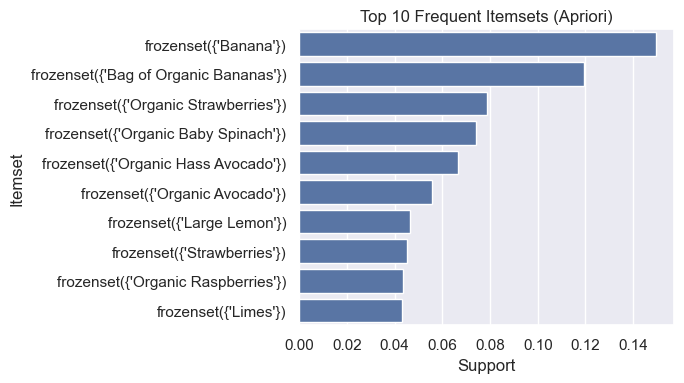

In [3]:
# ============================================
# STEP 2: FREQUENT ITEMSETS USING APRIORI
# ============================================

# Choose a support threshold based on dataset size
# 0.01 = itemset appears in at least 1% of all baskets
min_support = 0.01

freq_apriori = apriori(
    basket_df,
    min_support=min_support,
    use_colnames=True
)

freq_apriori["length"] = freq_apriori["itemsets"].apply(len)

print("Apriori frequent itemsets found:", freq_apriori.shape[0])
display(freq_apriori.sort_values("support", ascending=False).head(10))

# Visualize top N frequent itemsets discovered by Apriori
top_n_sets = 10
topA = freq_apriori.sort_values("support", ascending=False).head(top_n_sets)

plt.figure(figsize=(7, 4))
sns.barplot(x=topA["support"], y=topA["itemsets"].astype(str))
plt.title(f"Top {top_n_sets} Frequent Itemsets (Apriori)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()


FP-Growth frequent itemsets found: 121


,support,itemsets,length
10,0.14965,(Banana),1
5,0.11950,(Bag of Organic Bananas),1
11,0.07865,(Organic Strawberries),1
2,0.07400,(Organic Baby Spinach),1
6,0.06670,(Organic Hass Avocado),1
12,0.05575,(Organic Avocado),1
33,0.04635,(Large Lemon),1
44,0.04530,(Strawberries),1
7,0.04330,(Organic Raspberries),1
58,0.04305,(Limes),1


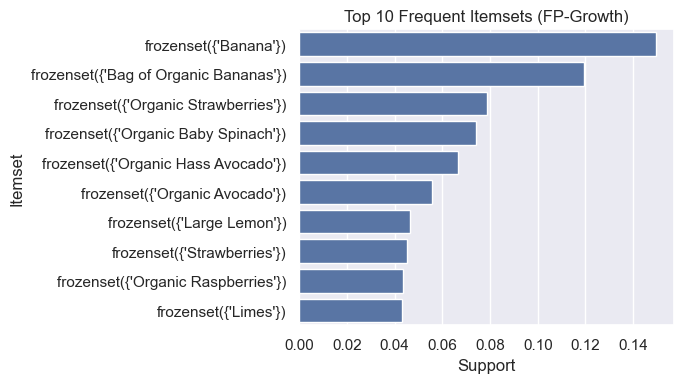

In [4]:
# ============================================
# STEP 3: FREQUENT ITEMSETS USING FP-GROWTH
# ============================================

# Use the same min_support so we can compare fairly with Apriori
freq_fp = fpgrowth(
    basket_df,
    min_support=min_support,
    use_colnames=True
)

freq_fp["length"] = freq_fp["itemsets"].apply(len)

print("FP-Growth frequent itemsets found:", freq_fp.shape[0])
display(freq_fp.sort_values("support", ascending=False).head(10))

# Visualize top N frequent itemsets discovered by FP-Growth
topF = freq_fp.sort_values("support", ascending=False).head(top_n_sets)

plt.figure(figsize=(7, 4))
sns.barplot(x=topF["support"], y=topF["itemsets"].astype(str))
plt.title(f"Top {top_n_sets} Frequent Itemsets (FP-Growth)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()


Rules from Apriori: 3
Rules from FP-Growth: 3


,antecedents,consequents,support,confidence,lift
2,(Organic Fuji Apple),(Banana),0.0105,0.381125,2.546777
0,(Cucumber Kirby),(Banana),0.0108,0.352365,2.354597
1,(Organic Avocado),(Banana),0.0169,0.303139,2.025653


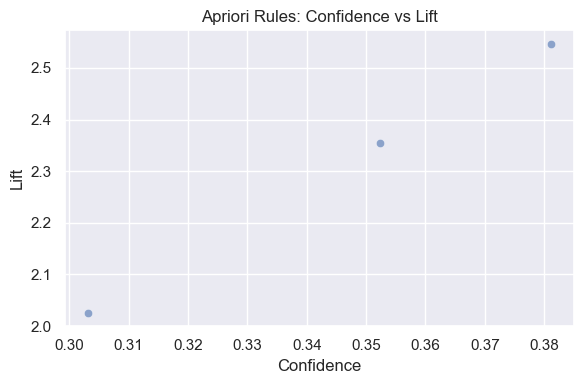

,antecedents,consequents,support,confidence,lift
2,(Organic Fuji Apple),(Banana),0.0105,0.381125,2.546777
1,(Cucumber Kirby),(Banana),0.0108,0.352365,2.354597
0,(Organic Avocado),(Banana),0.0169,0.303139,2.025653


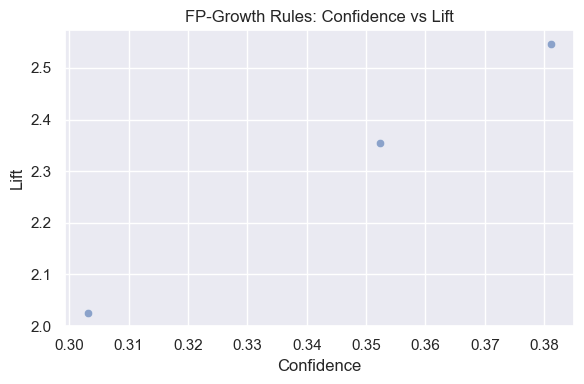

In [5]:
# ============================================
# STEP 4: ASSOCIATION RULE GENERATION
# ============================================

min_confidence = 0.3  # adjust as needed

# Rules from Apriori itemsets
if not freq_apriori.empty:
    rules_apriori = association_rules(
        freq_apriori,
        metric="confidence",
        min_threshold=min_confidence
    )
    print("Rules from Apriori:", rules_apriori.shape[0])
else:
    rules_apriori = pd.DataFrame()
    print("No Apriori itemsets found. Skipping Apriori rules.")

# Rules from FP-Growth itemsets
if not freq_fp.empty:
    rules_fp = association_rules(
        freq_fp,
        metric="confidence",
        min_threshold=min_confidence
    )
    print("Rules from FP-Growth:", rules_fp.shape[0])
else:
    rules_fp = pd.DataFrame()
    print("No FP-Growth itemsets found. Skipping FP-Growth rules.")

# Show strongest Apriori rules by lift (if any)
if not rules_apriori.empty:
    strongA = rules_apriori.sort_values(
        ["lift", "confidence"],
        ascending=False
    ).head(10)

    display(strongA[["antecedents", "consequents", "support", "confidence", "lift"]])

    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=rules_apriori,
        x="confidence",
        y="lift",
        alpha=0.6
    )
    plt.title("Apriori Rules: Confidence vs Lift")
    plt.xlabel("Confidence")
    plt.ylabel("Lift")
    plt.tight_layout()
    plt.show()

# Show strongest FP-Growth rules by lift (if any)
if not rules_fp.empty:
    strongF = rules_fp.sort_values(
        ["lift", "confidence"],
        ascending=False
    ).head(10)

    display(strongF[["antecedents", "consequents", "support", "confidence", "lift"]])

    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=rules_fp,
        x="confidence",
        y="lift",
        alpha=0.6
    )
    plt.title("FP-Growth Rules: Confidence vs Lift")
    plt.xlabel("Confidence")
    plt.ylabel("Lift")
    plt.tight_layout()
    plt.show()


In [6]:
# ============================================
# STEP 5: COMPARATIVE ANALYSIS
# ============================================

print("Apriori itemsets:", freq_apriori.shape[0])
print("FP-Growth itemsets:", freq_fp.shape[0])

if 'rules_apriori' in locals() and not rules_apriori.empty:
    print("Apriori rules:", rules_apriori.shape[0])
else:
    print("Apriori rules: 0 (no rules generated)")

if 'rules_fp' in locals() and not rules_fp.empty:
    print("FP-Growth rules:", rules_fp.shape[0])
else:
    print("FP-Growth rules: 0 (no rules generated)")

# Overlap in frequent itemsets (only if both non-empty)
if not freq_apriori.empty and not freq_fp.empty:
    setA = set(freq_apriori["itemsets"])
    setF = set(freq_fp["itemsets"])
    overlap = len(setA.intersection(setF))
    print("Overlap in frequent itemsets (Apriori vs FP-Growth):", overlap)
else:
    print("Cannot compute overlap – one of the itemset DataFrames is empty.")

# Optional: save strongest rules to CSV
if 'strongA' in locals():
    strongA.to_csv("./top_rules_apriori_instacart.csv", index=False)
if 'strongF' in locals():
    strongF.to_csv("./top_rules_fpgrowth_instacart.csv", index=False)

print("Done.")


Apriori itemsets: 121
FP-Growth itemsets: 121
Apriori rules: 3
FP-Growth rules: 3
Overlap in frequent itemsets (Apriori vs FP-Growth): 121
Done.
